In [1]:
import pandas as pd
import numpy as np
import itertools

# 2. 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# 3. 유틸
# tqdm 패키지는 반복문에 대해 얼마나 진척되었는지를 가시적으로 확인할 수 있도록 도와줍니다.
# https://github.com/tqdm/tqdm 사용법은 정말 간단합니다.
from tqdm.auto import tqdm


# 4. 설정
# 경고가 나와서, 출력이 많아지지 않기 위해 ignore를 설정해주었습니다.
import warnings
warnings.filterwarnings('ignore')


# 5. stats models
# 시계열 모델을 위한 ARIMA를 임포트 해주었습니다.
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [2]:
train_x = pd.read_csv("train_x_df.csv")
train_y = pd.read_csv("train_y_df.csv")

In [67]:
test_x = pd.read_csv("test_x_df.csv")

In [3]:
def buy_sell(signal, col1, col2):
    sigPriceBuy = []
    flag = -1

    for i in range(0, len(signal)):
        if signal[col1][i] > signal[col2][i] and flag != 1:
            sigPriceBuy.append(signal['close'][i])
            flag = 1

        elif signal[col1][i] < signal[col2][i] and flag != 0:
            sigPriceBuy.append(np.nan)
            flag = 0

        else:
            sigPriceBuy.append(np.nan)
    
    return (sigPriceBuy)

In [11]:
def make_obv(my_df):
    
    result = []

    for sample_id in my_df['sample_id'].unique().tolist():
        df = my_df[my_df['sample_id'] == sample_id]
        df.reset_index(inplace=True)
        OBV = []
        OBV.append(0)
        for i in range(1, len(df.close)):
            if df.close[i] > df.close[i-1]:
                OBV.append(OBV[-1] + df.volume[i])
            elif df.close[i] < df.close[i-1]:
                OBV.append(OBV[-1] - df.volume[i])
            else:
                OBV.append(OBV[-1])

        df['OBV'] = OBV
        df['OBV_EMA'] = df['OBV'].ewm(com=20).mean()

        buy_signal_price = buy_sell(df, 'OBV', 'OBV_EMA')
        df['Buy_Signal_Price'] = buy_signal_price

        result.append(df)                 

    output = pd.concat(result, axis=0)

    return output

In [9]:
train_x = train_x[train_x['sample_id'] < 760]

In [12]:
train_x = make_obv(train_x)

In [13]:
train_x

,index,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,OBV,OBV_EMA,Buy_Signal_Price
0,0,0,0,0,0.993147,0.993546,0.992857,0.992966,1.379478e+03,3778.584961,11.240029,329.655548,903.091614,0.000000e+00,0.000000e+00,NaN
1,1,0,1,0,0.993256,0.993546,0.992712,0.992712,3.438807e+03,9419.426758,11.602611,1363.999268,3737.512695,-3.438807e+03,-1.761340e+03,NaN
2,2,0,2,0,0.992748,0.994815,0.992458,0.994815,3.714949e+03,10173.972656,19.579407,1222.802856,3350.688721,2.761421e+02,-1.048787e+03,0.994815
3,3,0,3,0,0.994779,0.995286,0.994090,0.994996,2.430265e+03,6666.315430,15.591008,520.159546,1426.920776,2.706407e+03,-4.020695e+01,NaN
4,4,0,4,0,0.994561,0.994779,0.993727,0.994779,3.062139e+03,8395.172852,15.228427,2166.334473,5939.279785,-3.557327e+02,-1.096150e+02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1048795,759,1375,5,1.004125,1.004125,1.004125,1.004125,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-6.631153e+08,-6.510179e+08,NaN
1376,1048796,759,1376,5,1.007906,1.008250,1.007906,1.008250,1.321176e+06,38745.421875,137.504303,857758.625000,25153.402344,-6.617941e+08,-6.515311e+08,NaN
1377,1048797,759,1377,5,1.008250,1.008938,1.003094,1.003094,1.687178e+05,4944.845703,103.128220,86057.062500,2525.774902,-6.619628e+08,-6.520278e+08,NaN
1378,1048798,759,1378,5,1.002750,1.002750,1.001719,1.001719,2.927535e+05,8533.590820,137.504303,0.000000,0.000000,-6.622556e+08,-6.525149e+08,NaN


In [14]:
TRAIN_SAMPLE_ID_LIST = train_x["sample_id"].unique().tolist()

In [68]:
test_x = make_obv(test_x)

In [69]:
TEST_SAMPLE_ID_LIST = test_x["sample_id"].unique().tolist()

In [15]:
def get_OBV(df,sample_id):    
    return df[df["sample_id"] == sample_id]['OBV'].values
def get_OBV_EMA(df,sample_id):
    return df[df["sample_id"] == sample_id]['OBV_EMA'].values


In [42]:
# AIC 값이 최소인 p,d,q 값 직접 구하기
def model_fit(df, sample_id_list):
    result = []

    for sample_id in tqdm(sample_id_list):

        obv = get_OBV(df, sample_id)
        obv_ema = get_OBV_EMA(df, sample_id)

        # 2. ARIMA
        # 1) 모델 정의
        ARIMA_MODEL = {}
        ARIMA_MODEL_FIT = {}

        # 2) AR 모델 적용
        try:
            ARIMA_MODEL = ARIMA(obv, order = (5,1,1))
            ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

        # 3) 수렴하지 않을 경우 p d q 를 1, 1, 0으로 사용
        except:
            ARIMA_MODEL = ARIMA(obv, order = (4,1,0))
            ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

        # 4) ARIMA 예측
        ARIMA_FORECAST  = ARIMA_MODEL_FIT.predict(1,120, typ='levels')

        # 3. 데이처 처리
        # 1) 최대 부분인 인덱스를 찾는데 해당 시점에 매도를 진행합니다.
        sell_time = np.argmax(ARIMA_FORECAST)

        # 2) 최대값을 찾습니다.
        max_val = np.max(ARIMA_FORECAST)

        obv_last_val = obv[1379]
        obv_ema_last_val = obv_ema[1379]

        # 4. 투자 전략
        buy_quantity = 0

        # 1) typical_price가 1.1 이상이면 투자합니다.
        if max_val / obv_last_val > 1.4:
            buy_quantity = 1
        if obv_ema_last_val < obv_ema_last_val:
            buy_quantity = 1

        # 5. 결과
        result_list = [
                        sample_id,
                        buy_quantity,
                        sell_time,
                    ]

        result.append(result_list)

    return result

In [37]:
# result = model_fit(test_x, TEST_SAMPLE_ID_LIST)
result = model_fit(train_x, TRAIN_SAMPLE_ID_LIST)

100%|██████████| 760/760 [05:20<00:00,  2.37it/s]


In [38]:
submit_columns = [
                  "sample_id", 
                  "buy_quantity", 
                  "sell_time",
                  ]

submit = pd.DataFrame(data=result, columns=submit_columns)

In [39]:
#투자할 sample_id 갯수 확인
submit[submit["buy_quantity"] == 1].shape[0]  

32

In [20]:
train_y = train_y[train_y['sample_id'] < 760]

In [21]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)

    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [40]:
total_money, total_money_list = COIN(train_y, submit)

In [41]:
total_money

10073.870149899873

In [115]:
buy = train_x[train_x['Buy_Signal_Price'] > 0.1]

In [118]:
index = len(buy-1)
index

41149

In [81]:
FILE_NAME = "/0617_AUTO_ARIMA_OBV__MAXVAL_2_SUBMIT.csv"

In [82]:
SUBMIT_PATH = "./data"
RESULT_PATH = SUBMIT_PATH + FILE_NAME

submit.to_csv(RESULT_PATH, index=False)

In [60]:
my_df = train_x[train_x['sample_id'] == 100]

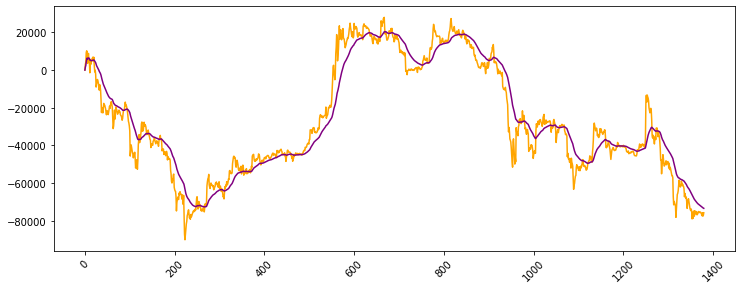

In [44]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(my_df['OBV'], label='OBV', color='orange')
plt.plot(my_df['OBV_EMA'],  label='OBV_EMA', color='purple')
plt.xticks(rotation=45)
plt.show()

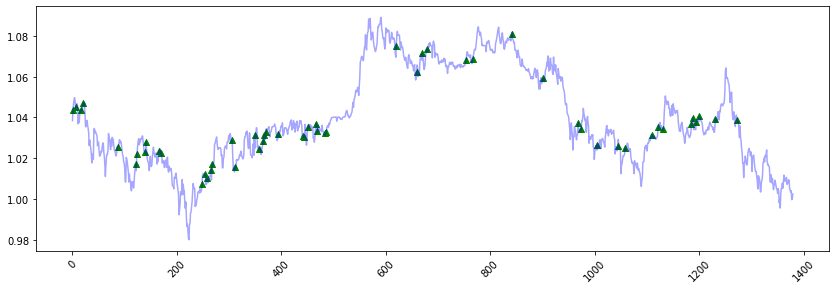

In [66]:
plt.figure(figsize=(14.2, 4.5))
plt.scatter(my_df.index, my_df['Buy_Signal_Price'], color='green', marker='^', alpha=1)
plt.plot(my_df['close'], label='close', color='blue',  alpha=0.35)
plt.xticks(rotation=45)
plt.show()